In [111]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM, SimpleRNN, GRU, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Flatten
%matplotlib inline

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [112]:
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import fbeta_score, make_scorer

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [113]:
df=pd.read_csv('https://raw.githubusercontent.com/khwanck/DeepMyeSequence/main/dataset/spam.csv',delimiter=',',encoding='latin-1')

In [114]:
# drop unuse columns
df.rename(columns={'v1':'target','v2':'sms'},inplace=True)
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
df.dropna()
df.drop_duplicates()
df.head()

,target,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## LabelEncoding Target Column

In [115]:
from sklearn.preprocessing import LabelEncoder

In [116]:
le=LabelEncoder()

In [117]:
df['target']=le.fit_transform(df['target'])

## train_test_split

In [118]:
x=df['sms']
y=df['target']

In [119]:
x_train,X_test,y_train,Y_test=train_test_split(x,y,test_size=0.2,random_state=20)
x_test,x_val,y_test,y_val=train_test_split(X_test,Y_test,test_size=0.5,random_state=20)

## Process train dataset

num_word = the maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept.

maxlen = Optional Int, maximum length of all sequences. If not provided, sequences will be padded to the length of the longest individual sequence.

Tokenizer = Tokenize the data and convert the text to sequences.

padding = String, 'pre' or 'post' (optional, defaults to 'pre'): pad either before or after each sequence.

pad_sequences = Add padding to ensure that all the sequences have the same shape

In [120]:
max_words=1000
max_len=172
token=Tokenizer(num_words=max_words)
token.fit_on_texts(df['sms'])
sequences=token.texts_to_sequences(x_train)
sequences_metrix=sequence.pad_sequences(sequences,padding='post',maxlen=max_len)

In [121]:
val_sequences = token.texts_to_sequences(x_val)
val_sequences_matrix = sequence.pad_sequences(val_sequences,padding='post',maxlen=max_len)

## Process test dataset

In [122]:
# process test data
test_sequences = token.texts_to_sequences(x_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,padding='post',maxlen=max_len)

In [123]:
sequences_metrix.shape,y_train.shape # shape of train dataset

((4457, 172), (4457,))

## define model

In [124]:
val_sequences_matrix.shape,y_val.shape 

((558, 172), (558,))

In [125]:
test_sequences_matrix.shape,y_test.shape # shape of test dataset

((557, 172), (557,))

In [126]:
test_sequences_matrix

array([[ 43, 510,  41, ...,   0,   0,   0],
       [477,   5,  43, ...,   0,   0,   0],
       [476,  82,  33, ...,   0,   0,   0],
       ...,
       [  9,   7, 267, ...,   0,   0,   0],
       [ 34, 264,  25, ...,   0,   0,   0],
       [ 27,   3,  70, ...,   0,   0,   0]], dtype=int32)

In [127]:
model=Sequential()

# embedding layer
model.add(Embedding(max_words,50,input_length=max_len,trainable=True))

# lstm layer
model.add(LSTM(100,return_sequences=True,dropout=0.5))
model.add(Flatten()) 
# Dense layer
model.add(Dense(200,activation='relu',name='hl1')) # hidden layer 1
model.add(Dense(100,activation='relu',name='hl2')) # hidden layer 2
model.add(Dense(1,activation='sigmoid',name='ol')) # output layer


    
# Add loss function, metrics, optimizer
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["accuracy"])

# Adding callbacks
#es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1,patience=3)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 172, 50)           50000     
                                                                 
 lstm_3 (LSTM)               (None, 172, 100)          60400     
                                                                 
 flatten_5 (Flatten)         (None, 17200)             0         
                                                                 
 hl1 (Dense)                 (None, 200)               3440200   
                                                                 
 hl2 (Dense)                 (None, 100)               20100     
                                                                 
 ol (Dense)                  (None, 1)                 101       
                                                                 
Total params: 3,570,801
Trainable params: 3,570,801
No

In [128]:
checkpoint_filepath = "LSTM_bestmodel_epoch{epoch:03d}.hdf5" 
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, \
                                                               save_weights_only=False, monitor='val_loss', \
                                                               mode='min')

## Train model

In [129]:
# Train model
tik = time.time()
#history=model.fit(sequences_metrix,y_train,batch_size=150,epochs=20,callbacks=[es],validation_split=0.2,verbose=1)
history=model.fit( sequences_metrix, y_train, \
                   validation_data=(val_sequences_matrix,y_val), \
                   batch_size=64, epochs=20 )
tok = time.time()
print(tik, tok, tok-tik)

Epoch 1/20
70/70 [==============================] - 3s 19ms/step - loss: 0.2151 - accuracy: 0.9273 - val_loss: 0.0633 - val_accuracy: 0.9821
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 0.0552 - accuracy: 0.9836 - val_loss: 0.0544 - val_accuracy: 0.9857
Epoch 3/20
70/70 [==============================] - 1s 12ms/step - loss: 0.0359 - accuracy: 0.9895 - val_loss: 0.0478 - val_accuracy: 0.9892
Epoch 4/20
70/70 [==============================] - 1s 12ms/step - loss: 0.0238 - accuracy: 0.9930 - val_loss: 0.0453 - val_accuracy: 0.9946
Epoch 5/20
70/70 [==============================] - 1s 12ms/step - loss: 0.0175 - accuracy: 0.9951 - val_loss: 0.0553 - val_accuracy: 0.9875
Epoch 6/20
70/70 [==============================] - 1s 12ms/step - loss: 0.0140 - accuracy: 0.9955 - val_loss: 0.0874 - val_accuracy: 0.9857
Epoch 7/20
70/70 [==============================] - 1s 12ms/step - loss: 0.0184 - accuracy: 0.9942 - val_loss: 0.0585 - val_accuracy: 0.9875
Epoch 8/20
70

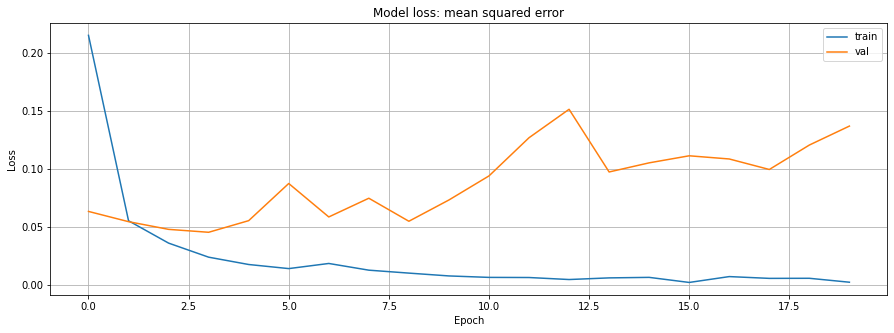

In [130]:
# Plot training & validation loss values 
plt.figure(figsize=(15,5)) 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss: mean squared error') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['train', 'val'], loc='upper right') 
plt.grid()
plt.show()

In [131]:
#import os 
#bestmodel_path = max( [f for f in os.listdir(".") if f. startswith('LSTM_bestmodel_') and f.endswith(".hdf5") ]) 
#best_model = tf.keras.models.load_model(bestmodel_path, compile=True) 
#print( f"The best model: {bestmodel_path}" ) 

## Evaluation model

In [132]:
# evaluation model
train_acc_lstm=model.evaluate(sequences_metrix,y_train,verbose=1) # train dataset evaluate
test_acc_lstm=model.evaluate(test_sequences_matrix,y_test,verbose=1) # test dataset evaluate
time_lstm = tok-tik

18/18 [==============================] - 0s 4ms/step - loss: 0.1111 - accuracy: 0.9856


In [133]:
print("Loss:{:.3f} and Accuracy:{:.3f}".format(train_acc_lstm[0],train_acc_lstm[1])) # train dataset Loss and Accurancy

Loss:0.001 and Accuracy:1.000


In [134]:
print("Loss:{:.3f} and Accuracy:{:.3f}".format(test_acc_lstm[0],test_acc_lstm[1])) # test dataset Loss and Accurancy

Loss:0.111 and Accuracy:0.986


## plot training history

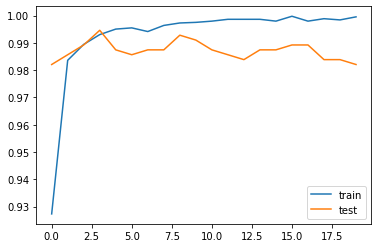

In [135]:
# plot training history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [136]:
# SimpleRNN model
model = Sequential()

# embedding layer
model.add(Embedding(max_words,50,input_length=max_len,trainable=True))

# lstm layer
model.add(SimpleRNN(100,return_sequences=True,dropout=0.5))
model.add(Flatten()) 
# Dense layer
model.add(Dense(200,activation='relu',name='hl1')) # hidden layer 1
model.add(Dense(100,activation='relu',name='hl2')) # hidden layer 2
model.add(Dense(1,activation='sigmoid',name='ol')) # output layer


    
# Add loss function, metrics, optimizer
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["accuracy"])

# Adding callbacks
#es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1,patience=3)

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 172, 50)           50000     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 172, 100)          15100     
                                                                 
 flatten_6 (Flatten)         (None, 17200)             0         
                                                                 
 hl1 (Dense)                 (None, 200)               3440200   
                                                                 
 hl2 (Dense)                 (None, 100)               20100     
                                                                 
 ol (Dense)                  (None, 1)                 101       
                                                                 
Total params: 3,525,501
Trainable params: 3,525,501
No

In [137]:
# Train model
tik = time.time()
#history=model.fit(sequences_metrix,y_train,batch_size=150,epochs=20,callbacks=[es],validation_split=0.2,verbose=1)
history=model.fit( sequences_metrix, y_train, \
                   validation_data=(val_sequences_matrix,y_val), \
                   batch_size=64, epochs=20 )
tok = time.time()
print(tik, tok, tok-tik)

Epoch 1/20
70/70 [==============================] - 13s 169ms/step - loss: 0.1967 - accuracy: 0.9190 - val_loss: 0.0761 - val_accuracy: 0.9785
Epoch 2/20
70/70 [==============================] - 11s 158ms/step - loss: 0.0597 - accuracy: 0.9812 - val_loss: 0.0630 - val_accuracy: 0.9803
Epoch 3/20
70/70 [==============================] - 11s 157ms/step - loss: 0.0399 - accuracy: 0.9897 - val_loss: 0.0564 - val_accuracy: 0.9839
Epoch 4/20
70/70 [==============================] - 11s 160ms/step - loss: 0.0325 - accuracy: 0.9897 - val_loss: 0.0745 - val_accuracy: 0.9875
Epoch 5/20
70/70 [==============================] - 11s 163ms/step - loss: 0.0252 - accuracy: 0.9935 - val_loss: 0.0882 - val_accuracy: 0.9839
Epoch 6/20
70/70 [==============================] - 11s 158ms/step - loss: 0.0379 - accuracy: 0.9919 - val_loss: 0.1154 - val_accuracy: 0.9821
Epoch 7/20
70/70 [==============================] - 11s 159ms/step - loss: 0.0367 - accuracy: 0.9915 - val_loss: 0.0803 - val_accuracy: 0.9839

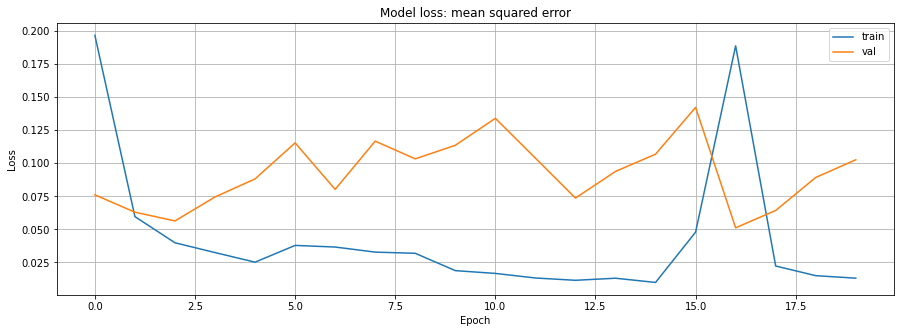

In [138]:
# Plot training & validation loss values 
plt.figure(figsize=(15,5)) 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss: mean squared error') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['train', 'val'], loc='upper right') 
plt.grid()
plt.show()

In [139]:
# evaluation model
train_acc_rnn=model.evaluate(sequences_metrix,y_train,verbose=1) # train dataset evaluate
test_acc_rnn=model.evaluate(test_sequences_matrix,y_test,verbose=1) # test dataset evaluate
time_rnn = tok-tik

18/18 [==============================] - 0s 15ms/step - loss: 0.0645 - accuracy: 0.9856


In [142]:
print("Loss:{:.3f} and Accuracy:{:.3f}".format(train_acc_rnn[0],train_acc_rnn[1])) # train dataset Loss and Accurancy
print("Loss:{:.3f} and Accuracy:{:.3f}".format(test_acc_rnn[0],test_acc_rnn[1])) # test dataset Loss and Accurancy

Loss:0.009 and Accuracy:0.998
Loss:0.064 and Accuracy:0.986


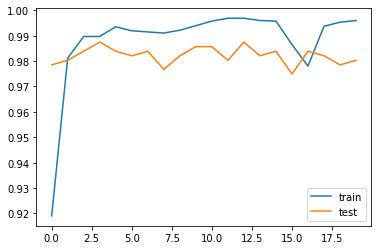

In [143]:
# plot training history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [144]:
# GRU model
model = Sequential()

# embedding layer
model.add(Embedding(max_words,50,input_length=max_len,trainable=True))

# lstm layer
model.add(GRU(100,return_sequences=True,dropout=0.5))
model.add(Flatten()) 
# Dense layer
model.add(Dense(200,activation='relu',name='hl1')) # hidden layer 1
model.add(Dense(100,activation='relu',name='hl2')) # hidden layer 2
model.add(Dense(1,activation='sigmoid',name='ol')) # output layer


    
# Add loss function, metrics, optimizer
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["accuracy"])

# Adding callbacks
#es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1,patience=3)

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 172, 50)           50000     
                                                                 
 gru_1 (GRU)                 (None, 172, 100)          45600     
                                                                 
 flatten_7 (Flatten)         (None, 17200)             0         
                                                                 
 hl1 (Dense)                 (None, 200)               3440200   
                                                                 
 hl2 (Dense)                 (None, 100)               20100     
                                                                 
 ol (Dense)                  (None, 1)                 101       
                                                                 
Total params: 3,556,001
Trainable params: 3,556,001
No

In [145]:
# Train model
tik = time.time()
#history=model.fit(sequences_metrix,y_train,batch_size=150,epochs=20,callbacks=[es],validation_split=0.2,verbose=1)
history=model.fit( sequences_metrix, y_train, \
                   validation_data=(val_sequences_matrix,y_val), \
                   batch_size=64, epochs=20 )
tok = time.time()
print(tik, tok, tok-tik)

Epoch 1/20
70/70 [==============================] - 3s 22ms/step - loss: 0.1997 - accuracy: 0.9287 - val_loss: 0.0737 - val_accuracy: 0.9767
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 0.0541 - accuracy: 0.9854 - val_loss: 0.0526 - val_accuracy: 0.9875
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 0.0357 - accuracy: 0.9890 - val_loss: 0.0604 - val_accuracy: 0.9875
Epoch 4/20
70/70 [==============================] - 1s 10ms/step - loss: 0.0257 - accuracy: 0.9926 - val_loss: 0.0522 - val_accuracy: 0.9875
Epoch 5/20
70/70 [==============================] - 1s 11ms/step - loss: 0.0189 - accuracy: 0.9946 - val_loss: 0.0831 - val_accuracy: 0.9839
Epoch 6/20
70/70 [==============================] - 1s 11ms/step - loss: 0.0136 - accuracy: 0.9962 - val_loss: 0.0732 - val_accuracy: 0.9875
Epoch 7/20
70/70 [==============================] - 1s 11ms/step - loss: 0.0103 - accuracy: 0.9969 - val_loss: 0.0657 - val_accuracy: 0.9928
Epoch 8/20
70

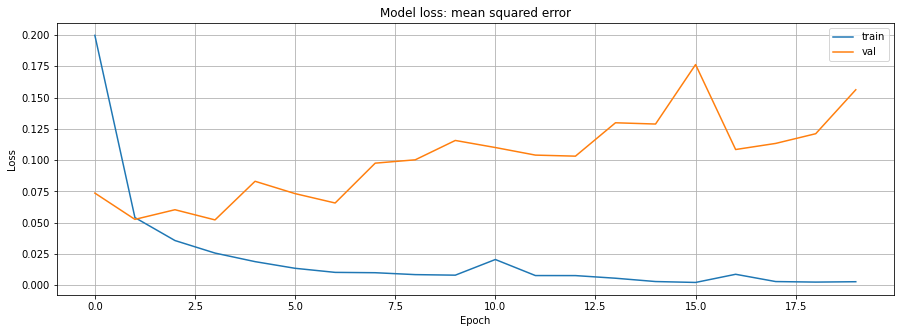

In [146]:
# Plot training & validation loss values 
plt.figure(figsize=(15,5)) 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss: mean squared error') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['train', 'val'], loc='upper right') 
plt.grid()
plt.show()

In [147]:
# evaluation model
train_acc_gru=model.evaluate(sequences_metrix,y_train,verbose=1) # train dataset evaluate
test_acc_gru=model.evaluate(test_sequences_matrix,y_test,verbose=1) # test dataset evaluate
time_gru = tok-tik

18/18 [==============================] - 0s 4ms/step - loss: 0.1191 - accuracy: 0.9838


In [148]:
print("Loss:{:.3f} and Accuracy:{:.3f}".format(train_acc_gru[0],train_acc_gru[1])) # train dataset Loss and Accurancy
print("Loss:{:.3f} and Accuracy:{:.3f}".format(test_acc_gru[0],test_acc_gru[1])) # test dataset Loss and Accurancy

Loss:0.001 and Accuracy:1.000
Loss:0.119 and Accuracy:0.984


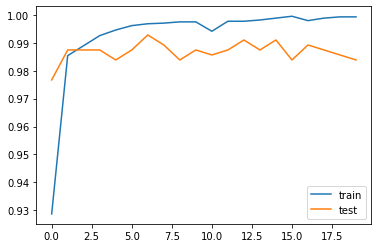

In [149]:
# plot training history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

# Traditional ML by NB vs SVM

In [156]:
df=pd.read_csv('https://raw.githubusercontent.com/khwanck/DeepMyeSequence/main/dataset/spam.csv',delimiter=',',encoding='latin-1')
# drop unuse columns
df.rename(columns={'v1':'target','v2':'sms'},inplace=True)
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
df.dropna()
df.drop_duplicates()
df.head()

,target,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


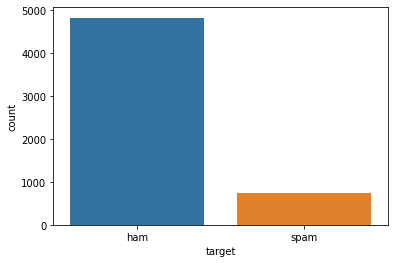

In [157]:
df_ml=df.copy()
sns.countplot(data = df_ml, x = 'target')

In [158]:
df_ml['target'] = df_ml.target.map({'ham':0, 'spam':1})

# Split dataset into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(df_ml.sms, df_ml.target, random_state = 42)

# Instantiate the TfidfVectorizer method and fit data
vector = TfidfVectorizer(stop_words = 'english')
training_data = vector.fit_transform(X_train)

# Transform testing data 
testing_data = vector.transform(X_test)
training_data.todense().shape

(4179, 7180)

In [159]:
#Training
# Instantiate all models
naive_bayes_clf = MultinomialNB()
random_forest_clf = RandomForestClassifier(n_estimators = 200)
svm_clf = SVC()

# Fit models with training data
tik = time.time()
naive_bayes_clf.fit(training_data, Y_train)
tok = time.time()
time_nb = tok-tik

tik = time.time()
random_forest_clf.fit(training_data, Y_train)
tok = time.time()
time_rf = tok-tik

tik = time.time()
svm_clf.fit(training_data, Y_train)
tok = time.time()
time_svm = tok-tik

In [160]:
#F-beta score as the evaluation
beta = 0.5
fbeta_scorer = make_scorer(fbeta_score, beta = beta)

def validation_score(model_name):
    scores = cross_val_score(model_name, 
                    training_data, Y_train, 
                    cv=10, scoring=fbeta_scorer) 
    return scores

In [161]:
nb_val_score = validation_score(naive_bayes_clf)
print(nb_val_score, "\n")
print("Average cross-validation F-beta score:", nb_val_score.mean())

[0.96707819 0.9623431  0.95238095 0.95338983 0.94298246 0.91981132
 0.96311475 0.91346154 0.94827586 0.91133005] 

Average cross-validation F-beta score: 0.9434168049209164


In [162]:
rf_val_score = validation_score(random_forest_clf)
print(rf_val_score, "\n")
print("Average cross-validation F-beta score:", rf_val_score.mean())

[0.97165992 0.951417   0.94142259 0.97222222 0.96774194 0.93181818
 0.97222222 0.95833333 0.97222222 0.93607306] 

Average cross-validation F-beta score: 0.9575132693881965


In [163]:
svm_val_score = validation_score(svm_clf)
print(svm_val_score, "\n")
print("Average cross-validation F-beta score:", svm_val_score.mean())

[0.94117647 0.96707819 0.95238095 0.94827586 0.95338983 0.90909091
 0.95338983 0.9375     0.95338983 0.91324201] 

Average cross-validation F-beta score: 0.9428913884087317


In [164]:
def testing_score(model):
    Y_pred = model.predict(testing_data)
    fbeta = fbeta_score(Y_test, Y_pred, beta = beta)
    return round(fbeta, 4)

def print_metrics(models, model_names):
    metrics_dict = {}
    for i in range(len(models)):
        metrics_dict[model_names[i]] = testing_score(models[i])
    return metrics_dict

models = [naive_bayes_clf, random_forest_clf, svm_clf]
model_names = ["Naive Bayes", "Random Forest", "Support Vector Machines"]

print_metrics(models, model_names)

{'Naive Bayes': 0.9387,
 'Random Forest': 0.9549,
 'Support Vector Machines': 0.9553}

In [168]:
# comparing the evaluation performance of all the models
fig = make_subplots(rows=1, cols=2, subplot_titles=('Evaluation Loss',  'Evaluation Accuracy'))

fig.add_trace(
    go.Bar(name='Loss', 
           x=['SimpleRNN', 'LSTM', 'GRU'], 
           y=[test_acc_rnn[0], test_acc_lstm[0], test_acc_gru[0]]),
           row=1, 
           col=1)

fig.add_trace(
    go.Bar(name='Accuracy', 
           x=['SimpleRNN', 'LSTM', 'GRU', 'NB', 'RF', 'SVM'], 
           y=[test_acc_rnn[1], test_acc_lstm[1], test_acc_gru[1], nb_val_score.mean(), rf_val_score.mean(), svm_val_score.mean()]),
           row=1, 
           col=2)

fig.update_layout(title_text='Evaulation Results')
fig.show()

In [169]:
# comparing the training time for each of the models 
fig = go.Figure()
fig.add_trace(go.Bar(name='Loss', 
                     x=['SimpleRNN', 'LSTM', 'GRU', 'NB', 'RF', 'SVM'], 
                     y=[time_rnn, time_lstm, time_gru, time_nb, time_rf, time_svm]))
fig.update_layout(title_text='Training time of each model')
fig.show()